# Prepare input for SANS calculation with PLUMED

In this Notebook, we start from an experimental curve for the small-angle neutron scattering (SANS) and generate input files for computing the SANS spectrum of molecular dynamics (MD) trajectories using PLUMED or perform metainference simulations with PLUMED.

## Step 1:
We start with some settings. Read the comments in the box below to understand the meaning of each variable.

In [32]:
# absolute path to the experimental SANS spectrum
EXPERIMENTAL_DATAFILE = "/home/hmcezar/Data/BOG/intensities.csv"
skiplines = 1 # number of lines to be skipped when reading the file (skip header)

# name for each column in the file
# it's important to have "q", "I(q)" and "sigma(q)" with these names here
# if you don't want to use the resolution function (or don't have the beamline parameters) just don't name a column as "sigma(q)"
namecols = ["q", "I(q)", "0.15M", "0.3M", "0.6M", "1.0M"]

# q range and number of points to be used
# more points => bigger computational cost (more SANS intensities are computed)
initial_q = 0.005
final_q = 0.24
total_n_points = 20

# if you want to manually include points around a region, specify the qs here
# otherwise, just leave this list empty
select_q = []

## Step 2:
Now we import the Python libraries and read the data into a Pandas dataframe.
Please adjust the `pd.read_csv()` line to your needs.

Then, we select the $q$ from the file and plot the selected points on top of the experimental curve.
Read all the comments to understand what the code is doing.
After running the cell below, check the output! Especially the plot to see if you like the selected $q$.

You asked for 20 points but 19 were generated!
Probably your experimental q are more spaced than the interval you selected


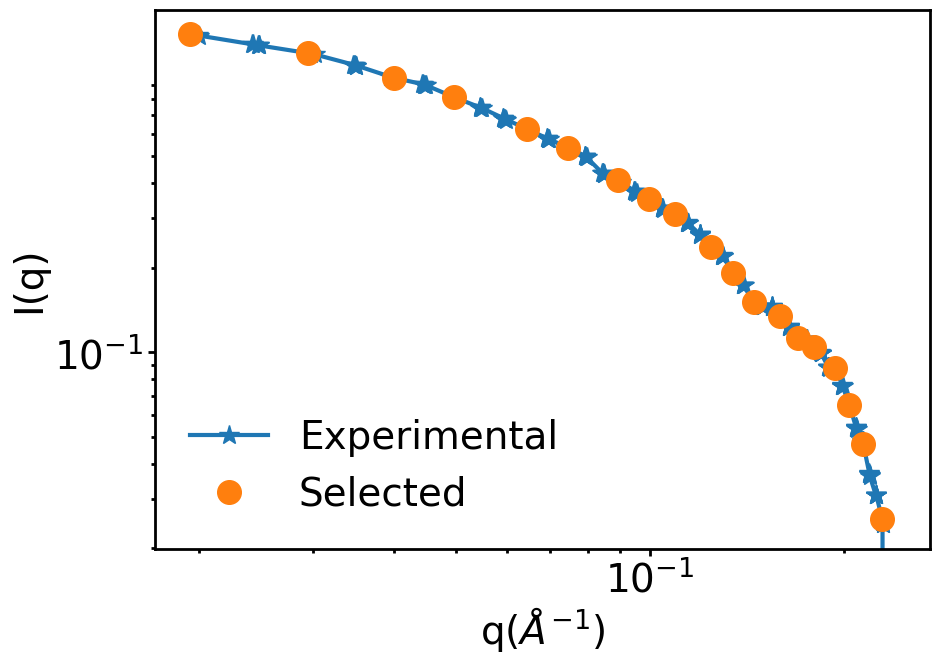

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# function to find closest value in a df
def find_closest(df, value):
    dist = (df["q"] - value).abs()
    return dist.idxmin()

# read the dataframe and store values in the desired interval
# adjust the line below according to your input file (for example, commas or spaces/tabs to separate columns)
# we provide two example that should work in most cases
df = pd.read_csv(EXPERIMENTAL_DATAFILE, header=None, comment="#", names=namecols, skiprows=skiplines) # commas as delimiter
# df = pd.read_csv(EXPERIMENTAL_DATAFILE, header=None, delimiter=r"\s+", comment="#", names=namecols, skiprows=skiplines) # spaces as delimiter

# prepare the data in the dataframe
df['I(q)'] = df['I(q)'].astype(float)
df = df[df["q"] >= initial_q]
df = df[df["q"] <= final_q]

# select the q automatically uniformly in the interval
n_points = total_n_points - len(select_q)
q_interval = (final_q - initial_q)/n_points
idxs = []
skipped = 0
for i in range(n_points):
    q_target = initial_q + i*q_interval
    closest = find_closest(df, q_target)
    if closest in idxs:
        skipped += 1
        continue
    idxs.append(closest)

# check if the right number of points were selected
if skipped != 0:
    print(f"You asked for {n_points} points but {n_points-skipped} were generated!")
    print("Probably your experimental q are more spaced than the interval you selected")
    
# add the "manually selected" q to the set
for q in select_q:
    found_q = find_closest(df, q)
    if found_q not in idxs:
        idxs.append(found_q)
    else:
        print("Value {} of select_q already included (considering {})".format(q, df.loc[found_q]["q"]))

# make output dataframe
out_df = df.loc[idxs]
out_df.sort_values(by=["q"], inplace=True)

# plot settings - change these according to your taste
plt.rc('lines', linewidth=3.0)
plt.rcParams["figure.figsize"] = (10,7)
plt.rcParams["font.size"] = 28

fig, ax = plt.subplots()
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
    
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=5)
ax.tick_params(which='minor', length=3)

# plot
ax.plot(df["q"], df["I(q)"], "*-", markersize=15, label="Experimental")
ax.plot(out_df["q"], out_df["I(q)"], "o", markersize=17, label="Selected")
plt.legend(loc="lower left", frameon=False)
plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"q($\AA^{-1}$)")
plt.ylabel(r"I(q)")
ax.set_yticks([0.1])
ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

# generate the formatted output of QVALUE/EXPINT/SIGMARES
out_q_exp = ""
for i, (idx, data) in enumerate(out_df.iterrows(),start=1):
    if "sigma(q)" in data.keys():
        out_q_exp += "  QVALUE{}={:.6f} EXPINT{}={:.8f} SIGMARES{}={:.6f}\n".format(i,data["q"],i,data["I(q)"],i,data["sigma(q)"])
    else:
        out_q_exp += "  QVALUE{}={:.6f} EXPINT{}={:.8f}\n".format(i,data["q"],i,data["I(q)"])

## Step 3a (see step 3b for metainference):
Check if the plot above satisfies your needs.
In principle, you should have the orange circles capturing the features of the curve.

With the right $q$ selected, we can proceed to generate the PLUMED input.
Using the template below, we setup the input for just computing the SANS intensities of each snapshot.

If you want to run metainference simulations, go to the cell below this one.

In [39]:
# SANS without metainference

# settings
REL_PATH_PDB = "./bog.pdb" # path to PDB containing the structure to be load with MOLINFO
ATOM_SELECTION = "1-740"   # scattering centers (indexes of atoms/beads) used to compute the SANS
STRIDE_PRINT = "100"       # stride for number of steps when the SANS intensities are computed

# template PLUMED input
template = f"""MOLINFO STRUCTURE={REL_PATH_PDB}

sansdata: SANS2 ...
  ATOMS={ATOM_SELECTION}

  SCATLENFILE=../scatlens.plumed

{out_q_exp}
...

PRINT ARG=(sansdata\.q-.*) STRIDE={STRIDE_PRINT} FILE=SANS_SPEC_CG

"""
        
# write to file
with open("plumed.input", "w") as f:
    f.write(template)
    
# print input to screen
print(template)

MOLINFO STRUCTURE=./bog.pdb

sansdata: SANS2 ...
  ATOMS=1-740

  SCATLENFILE=../scatlens.plumed

  QVALUE1=0.019333 EXPINT1=1.36130000
  QVALUE2=0.029422 EXPINT2=1.16650000
  QVALUE3=0.040082 EXPINT3=0.95130000
  QVALUE4=0.049705 EXPINT4=0.81060000
  QVALUE5=0.064369 EXPINT5=0.62540000
  QVALUE6=0.074650 EXPINT6=0.53650000
  QVALUE7=0.089256 EXPINT7=0.41050000
  QVALUE8=0.099562 EXPINT8=0.35300000
  QVALUE9=0.109363 EXPINT9=0.31000000
  QVALUE10=0.124402 EXPINT10=0.23810000
  QVALUE11=0.134489 EXPINT11=0.19120000
  QVALUE12=0.144929 EXPINT12=0.15090000
  QVALUE13=0.159407 EXPINT13=0.13480000
  QVALUE14=0.169506 EXPINT14=0.11240000
  QVALUE15=0.179522 EXPINT15=0.10480000
  QVALUE16=0.193550 EXPINT16=0.08770000
  QVALUE17=0.203974 EXPINT17=0.06480000
  QVALUE18=0.214229 EXPINT18=0.04720000
  QVALUE19=0.229310 EXPINT19=0.02540000

...

PRINT ARG=(sansdata\.q-.*) STRIDE=100 FILE=SANS_SPEC_CG




## Step 3b:
If you want to run metainference simulations using the SANS bias, use the template below.
Please change the settings and the template according to your needs.
For example, values for the offset or chuncksize might be different, or you might want to add the `SCALEDATA` and related keywords.

In [40]:
# SANS with metainference

# settings
REL_PATH_PDB = "./bog.pdb" # path to PDB containing the structure to be load with MOLINFO
ATOM_SELECTION = "1-740"   # scattering centers (indexes of atoms/beads) used to compute the SANS
STRIDE_PRINT = "100"       # stride for the number of steps between computing the SANS intensities
STRIDE_BIAS = "5"          # stride for the number of steps between applying the bias
max_factor = 0.085         # value for which the I(q) are multiplied to provide the SIGMA_MAX
min_factor = 0.25          # value for which the SIGMA_MAX are multiplied to provide the SIGMA_MIN
dsigma_factor = 0.035      # value for which the SIGMA_MAX are multiplied to provide the DSIGMA

# based on out_q_exp compute the SIGMA_MIN, SIGMA_MAX and DSIGMA
import numpy as np
np.set_printoptions(suppress=True)

sigmas = out_df["I(q)"]*mult_factor
sigmas_min = sigmas*min_factor
dsigma = sigmas*dsigma_factor

out_sigmas = "  SIGMA0="+np.array2string(sigmas.to_numpy(),separator=",").strip('[]').replace('\n','').replace(' ','')+"\n"
out_sigmas += "  SIGMA_MIN="+np.array2string(sigmas_min.to_numpy(),separator=",").strip('[]').replace('\n','').replace(' ','')+"\n"
out_sigmas += "  SIGMA_MAX="+np.array2string(sigmas.to_numpy(),separator=",").strip('[]').replace('\n','').replace(' ','')+"\n"
out_sigmas += "  DSIGMA="+np.array2string(dsigma.to_numpy(),separator=",").strip('[]').replace('\n','').replace(' ','')

# template PLUMED input
template = f"""MOLINFO STRUCTURE={REL_PATH_PDB}

sansdata: SANS2 ...
  ATOMS={ATOM_SELECTION}

  SCATLENFILE=../scatlens.plumed

{out_q_exp}
  # METAINFERENCE 
  DOSCORE NOENSEMBLE SIGMA_MEAN0=0
{out_sigmas}
  ADDOFFSET
  OFFSET0=0.0
  OFFSET_MIN=-0.2
  OFFSET_MAX=0.2
  DOFFSET=0.001
  NOISETYPE=MGAUSS
  MC_CHUNKSIZE=5
  MC_STEPS=4

...

# METAINFERENCE BIAS
sansbias: BIASVALUE ARG=(sansdata\.score) STRIDE={STRIDE_BIAS}

# STATISTICS
statcg: STATS ARG=(sansdata\.q-.*) PARARG=(sansdata\.exp-.*) 

PRINT ARG=(sansdata\.score),(sansdata\.acceptSigma),(sansdata\.offset),(sansdata\.sigma.*) STRIDE={STRIDE_PRINT} FILE=BAYES.SANS
PRINT ARG=(sansdata\.offset),(sansdata\.q-.*) STRIDE={STRIDE_PRINT} FILE=SANS_SPEC_CG
PRINT ARG=statcg.corr STRIDE={STRIDE_PRINT} FILE=ST.SANSCG

"""

# write to file
with open("plumed.input", "w") as f:
    f.write(template)
    
# print input to screen
print(template)

MOLINFO STRUCTURE=./bog.pdb

sansdata: SANS2 ...
  ATOMS=1-740

  SCATLENFILE=../scatlens.plumed

  QVALUE1=0.019333 EXPINT1=1.36130000
  QVALUE2=0.029422 EXPINT2=1.16650000
  QVALUE3=0.040082 EXPINT3=0.95130000
  QVALUE4=0.049705 EXPINT4=0.81060000
  QVALUE5=0.064369 EXPINT5=0.62540000
  QVALUE6=0.074650 EXPINT6=0.53650000
  QVALUE7=0.089256 EXPINT7=0.41050000
  QVALUE8=0.099562 EXPINT8=0.35300000
  QVALUE9=0.109363 EXPINT9=0.31000000
  QVALUE10=0.124402 EXPINT10=0.23810000
  QVALUE11=0.134489 EXPINT11=0.19120000
  QVALUE12=0.144929 EXPINT12=0.15090000
  QVALUE13=0.159407 EXPINT13=0.13480000
  QVALUE14=0.169506 EXPINT14=0.11240000
  QVALUE15=0.179522 EXPINT15=0.10480000
  QVALUE16=0.193550 EXPINT16=0.08770000
  QVALUE17=0.203974 EXPINT17=0.06480000
  QVALUE18=0.214229 EXPINT18=0.04720000
  QVALUE19=0.229310 EXPINT19=0.02540000

  # METAINFERENCE 
  DOSCORE NOENSEMBLE SIGMA_MEAN0=0
  SIGMA0=0.1157105,0.0991525,0.0808605,0.068901,0.053159,0.0456025,0.0348925,0.030005,0.02635,0.0202385,0